In [13]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
import numpy as np
import cv2
import utils
import trainer
import evaluator
import data_process
import motion_blur
from ultralytics import YOLO
import shutil

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

In [14]:
data_process.download_data()

input_size = 300

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
    torchvision.transforms.Normalize(mean=data_process.train_mean.tolist(), std=data_process.train_std.tolist())
])

train_set, val_set, test_set = data_process.load_data(transform=transform, input_size=input_size)

Data already exists

Number of valid images: 664
Train set size: 464 - 69.88%
Validation set size: 67 - 10.09%
Test set size: 133 - 20.03%



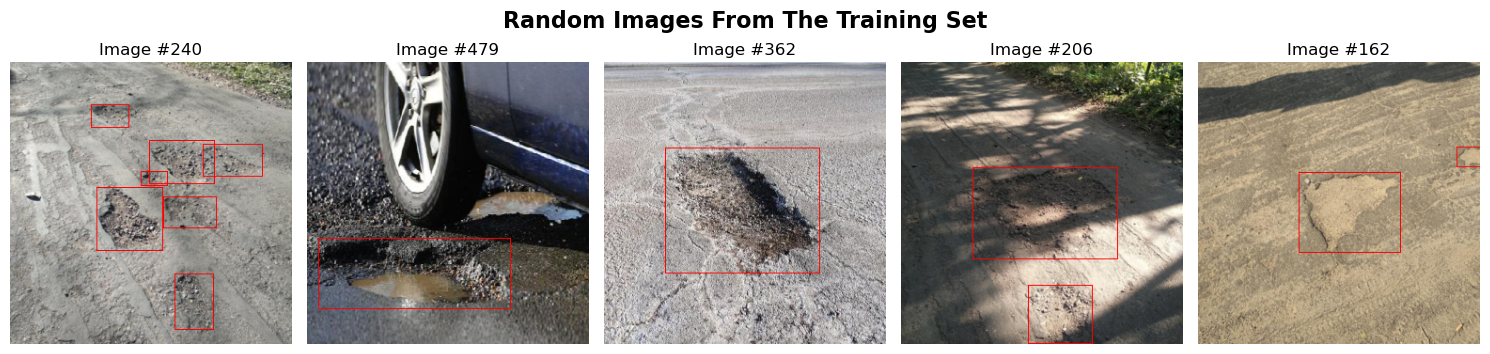

In [3]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=data_process.collate_fn)
images, targets = next(iter(train_loader))
data_process.show_images(images, targets, title="Random Images From The Training Set")

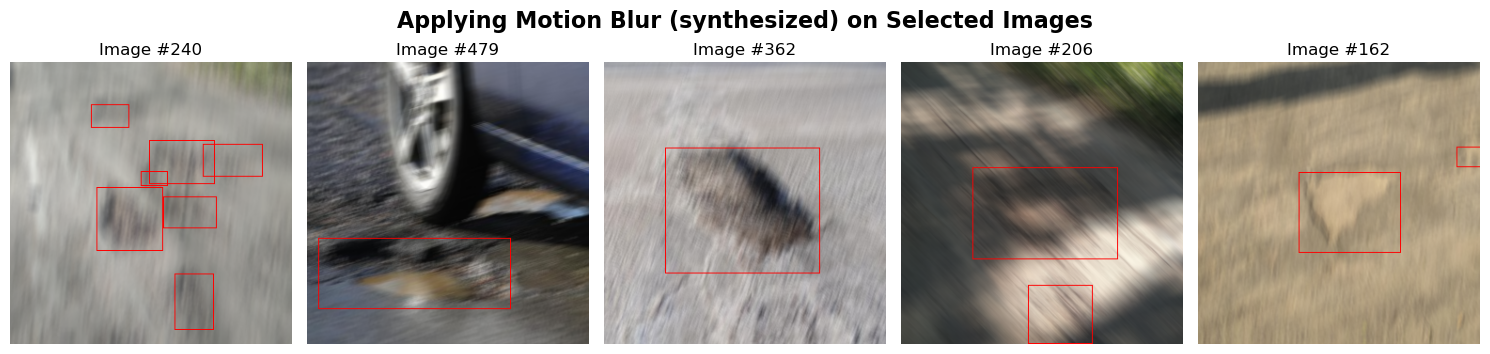

In [ ]:
# Apply synthesized motion blur kernel(s) on the randomly selected images 
ellipse_motion_blurred_images = []
ellipse_kernels = []

for image in images:
    # Apply a randomly generated motion blur kernel
    motion_blurred_image, kernel = motion_blur.motion_blur(
        image=image,
        kernel_type='ellipse',
        a=0.1, # in range [0,1], controls the severity of the motion blur effect
        return_kernel=True
    )
    ellipse_motion_blurred_images.append(motion_blurred_image)
    ellipse_kernels.append(kernel)

data_process.show_images(ellipse_motion_blurred_images, targets, title="Applying Motion Blur (synthesized ellipse kernel) on Selected Images")

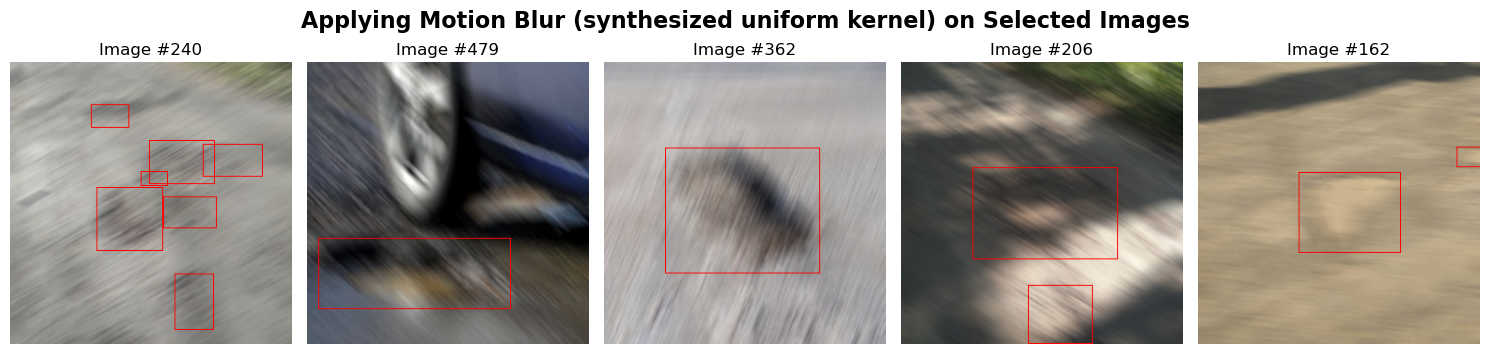

In [11]:
# Apply synthesized motion blur kernel(s) on the randomly selected images 
uniform_motion_blurred_images = []
uniform_kernels = []

for image in images:
    # Apply a randomly generated motion blur kernel
    motion_blurred_image, kernel = motion_blur.motion_blur(
        image=image,
        kernel_type='uniform',
        a=0.1, # in range [0,1], controls the severity of the motion blur effect
        return_kernel=True
    )
    uniform_motion_blurred_images.append(motion_blurred_image)
    uniform_kernels.append(kernel)

data_process.show_images(uniform_motion_blurred_images, targets, title="Applying Motion Blur (synthesized uniform kernel) on Selected Images")

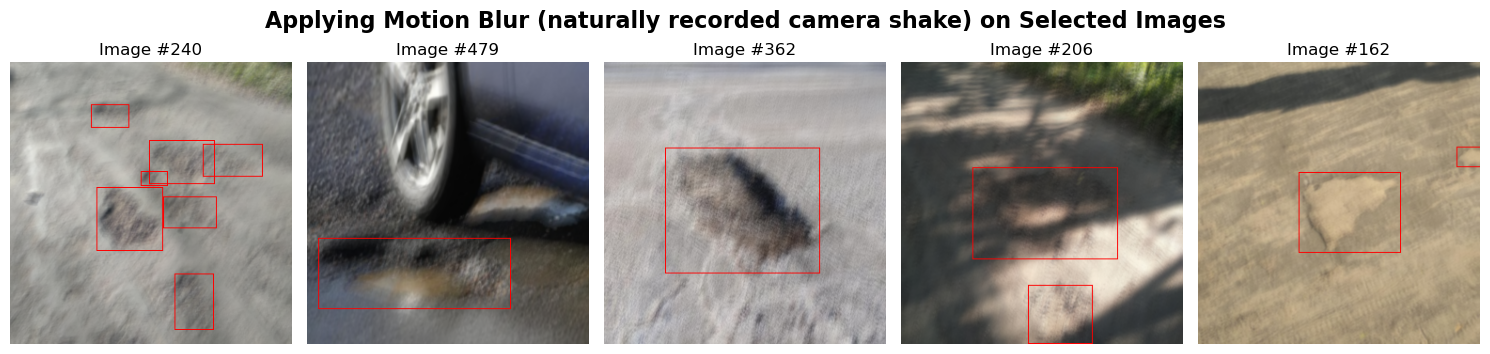

In [12]:
# Apply natural motion blur kernel(s) on the randomly selected images 
nat_motion_blurred_images = []
nat_kernels = []

for image in images:
    # Apply a randomly generated motion blur kernel
    motion_blurred_image, kernel = motion_blur.motion_blur(
        image=image,
        kernel_type='natural',
        return_kernel=True
    )
    nat_motion_blurred_images.append(motion_blurred_image)
    nat_kernels.append(kernel)

data_process.show_images(nat_motion_blurred_images, targets, title="Applying Motion Blur (naturally recorded camera shake) on Selected Images")

In [23]:
# check trainer
model = YOLO('yolov11.pt')

# Retrieve the list of input channels. 
num_classes = len(data_process.PotholeSeverity)
model.model.model[-1].nc = num_classes



# Image size for transforms.
model.transform.min_size = (input_size,)
model.transform.max_size = input_size

num_epochs = 20
batch_size = 5


train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_process.collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_process.collate_fn
)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009467475340372642, betas=(0.8834165199724515, 0.9690194026386639), weight_decay=0.0015812143275965708)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002747758441042921, epochs=num_epochs, steps_per_epoch=len(train_loader))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = trainer.train(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs, device=device, model_name="ssd300vgg16", save_path="./")

utils.update_json(history, model_name="ssd300vgg16", json_name="models_data.json", save_path="data")

KeyboardInterrupt: 

In [3]:
model_name = "fcos_resnet50_fpn"
study = trainer.run_optimization(model_name, train_set, val_set, n_trials=10, study_name=model_name, save_path=os.path.join("data/models", model_name))

[I 2025-01-25 19:12:07,226] A new study created in RDB with name: fcos_resnet50_fpn


Checking Model: FCOS
Starting Trial #0
Epoch 1/17, Train Loss: 256.0614, Val mAP@50: 0.0000, FPS: 59.57, Epoch Time: 19.96 seconds
Epoch 2/17, Train Loss: nan, Val mAP@50: 0.0000, FPS: 64.18, Epoch Time: 19.34 seconds
Epoch 3/17, Train Loss: nan, Val mAP@50: 0.0000, FPS: 64.16, Epoch Time: 19.22 seconds
Epoch 4/17, Train Loss: nan, Val mAP@50: 0.0000, FPS: 64.14, Epoch Time: 19.25 seconds


[I 2025-01-25 19:13:45,009] Trial 0 pruned. 


Trial pruned by Optuna at epoch 4.
Checking Model: FCOS
Starting Trial #1


[W 2025-01-25 19:13:52,876] Trial 1 failed with parameters: {'batch_size': 6, 'epochs': 13, 'preweight_mode': 'random', 'optimizer': 'Adam', 'lr': 0.0004904539339172869, 'beta1': 0.9169765854389738, 'beta2': 0.9282853454922604, 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.16714116943161034} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/user_138/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/user_138/046211-Deep-Learning/trainer.py", line 400, in objective
    history = train(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device=device, save_path=save_path_global, trial=trial)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/user_138/046211-Deep-Learning/tr

KeyboardInterrupt: 

Mean Average Precision @ 0.5 : 0.5158 FPS: 257.71


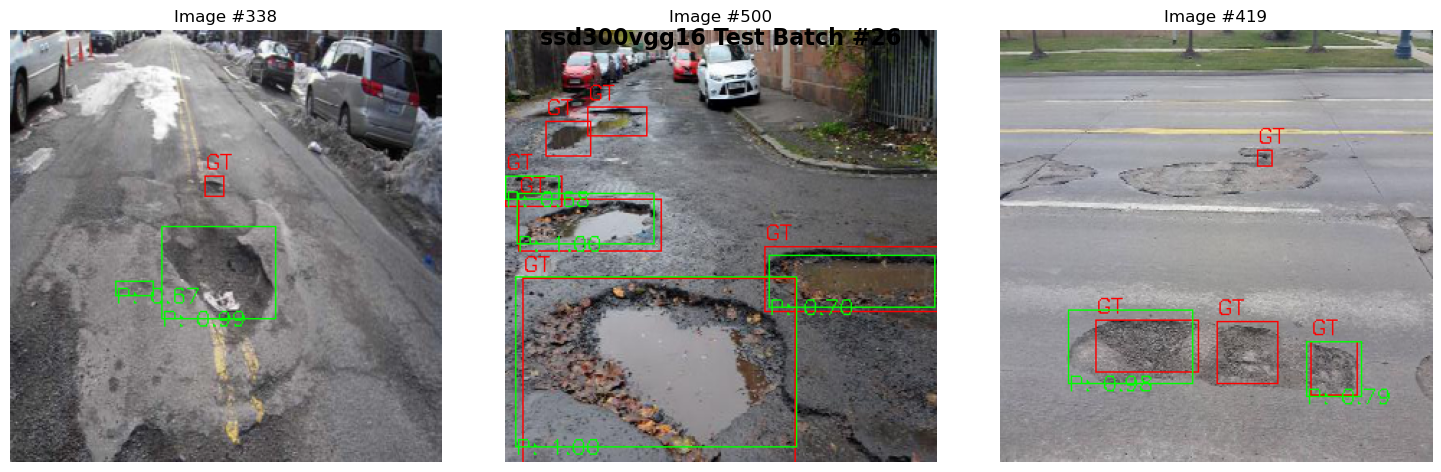

In [7]:
model = models.detection.ssd300_vgg16(num_classes=len(data_process.PotholeSeverity)) 
state_dict = torch.load("ssd300vgg16.pth", weights_only=True)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# test the model
evaluator.test_model(model, test_set, device=device, index=None, model_name="ssd300_vgg16")